### Imports and Data Loading

In [1]:
import datetime
import pathlib

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL, AutoETS
from utils import check_autocorr_ts
from utilsforecast.preprocessing import fill_gaps


#### Explode Data into Separate Columns

In [2]:
def parse_temperature_c(x):
    sign = x[0]
    num = x[1:].lstrip('0')
    if num == "9999":
        return np.NAN
    elif num:
        num = int(num)/10
    else:
        num = .0
    return num if sign == '+' else -num

In [3]:
# https://www.visualcrossing.com/resources/documentation/weather-data/how-we-process-integrated-surface-database-historical-weather-data/
def explode_temperature(df):
    temperature_exp = pd.DataFrame(
        df['TMP'].str.split(",").tolist(),
        columns = ['temperature_c','temp_obs_quality']
    )
    temperature_exp['temperature_c'] = temperature_exp['temperature_c'].apply(parse_temperature_c)
    return temperature_exp

def explode_wind(df):
    wind_exp = pd.DataFrame(
        df['WND'].str.split(",").tolist(),
        columns = ["direction_deg","direction_quality","observation_type", "speed_mps", "speed_quality"]
    )
    wind_exp['speed_mps'] = wind_exp['speed_mps'].astype('float64')/10
    wind_exp['direction_deg'] = wind_exp['direction_deg'].astype('uint16')
    return wind_exp

def explode_precip(df):
    df['AA1'] = df['AA1'].fillna('0,-1,-1,-1')
    precip_exp = pd.DataFrame(
        df['AA1'].str.split(",").tolist(),
        columns = ["precip_period_hrs","precip_accumulation_mm","precip_condition","precip_quality"]
    )
    precip_exp["precip_accumulation_mm"] = precip_exp["precip_accumulation_mm"].astype('float64')/10
    precip_exp["precip_period_hrs"] = precip_exp["precip_period_hrs"].astype('uint8')
    return precip_exp

def explode_dew(df):
    dew_exp = pd.DataFrame(
        df['DEW'].str.split(",").tolist(),
        columns = ['dew_temperature_c','dew_obs_quality']
    )
    dew_exp['dew_temperature_c'] = dew_exp['dew_temperature_c'].apply(parse_temperature_c)
    return dew_exp

def explode_vis(df):
    vis_exp = pd.DataFrame(
        df['VIS'].str.split(",").tolist(),
        columns = ["vis_distance_km","vis_dist_quality","vis_variablitiy", "vis_quality"]
    )
    vis_exp['vis_distance_km'] = vis_exp['vis_distance_km'].astype('float64')/1000
    return vis_exp

def explode_weather(df):
    temperature_exp = explode_temperature(df)
    precip_exp = explode_precip(df)
    wind_exp = explode_wind(df)
    dew_exp = explode_dew(df)

    weather_df = pd.concat([df, temperature_exp, precip_exp, wind_exp, dew_exp,],axis=1)
    weather_df.drop(['AA1','DEW','TMP','VIS', 'WND'], axis=1, inplace=True)
    weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
    weather_df['year'] = weather_df['DATE'].dt.strftime('%Y').astype(int)
    weather_df = weather_df.convert_dtypes(dtype_backend='pyarrow')
    return weather_df

#### Read Saved Data  
[Data Source](https://www.ncei.noaa.gov/access/search/data-search/global-hourly?dataTypes=TMP&dataTypes=DEW&dataTypes=AA1&dataTypes=VIS&dataTypes=WND&bbox=41.000,-74.261,40.558,-73.499&pageNum=1&startDate=2010-01-01T00:00:00&endDate=2023-02-01T23:59:59)  
[Type Documentation](https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf)

In [4]:

root_dir = pathlib.Path("../data")
weather_dir = root_dir/"weather"
save_dir = weather_dir/'unprocessed'
try:
    weather_df = pd.read_parquet(save_dir)
    if len(weather_df) == 0:
        raise FileNotFoundError
except FileNotFoundError:

    temp = pd.read_csv(weather_dir/"hourly_temp_laguardia.csv", dtype_backend='pyarrow')
    weather_df = explode_weather(temp)
    del temp
    weather_df.to_parquet(save_dir, partition_cols=['year'])


In [127]:
weather_df.describe().T.convert_dtypes()


,count,mean,min,25%,50%,75%,max,std
STATION,180354,72503014732.0,72503014732.0,72503014732.0,72503014732.0,72503014732.0,72503014732.0,0.0
DATE,180354,2016-07-21 21:44:01.692005376,2010-01-01 00:00:00,2013-04-16 02:06:00,2016-08-03 08:21:00,2019-10-22 23:24:30,2023-02-01 23:51:00,<NA>
SOURCE,180354,6.320248,4.0,6.0,7.0,7.0,7.0,1.21959
temperature_c,175370,13.635336,-17.2,5.6,13.9,22.0,39.4,9.742982
precip_period_hrs,180354,1.640829,0.0,1.0,1.0,1.0,24.0,4.073341
precip_accumulation_mm,180354,0.394182,-0.1,0.0,0.0,0.0,999.9,5.791086
direction_deg,180354,261.453985,10.0,90.0,220.0,310.0,999.0,247.40444
speed_mps,180354,33.027294,0.0,3.1,4.6,6.2,999.9,165.389137
dew_temperature_c,175357,5.918757,-27.2,-2.2,6.7,14.4,25.6,10.325693
year,180354,2016.060409,2010.0,2013.0,2016.0,2019.0,2023.0,3.764642


In [122]:
weather_df.describe(include='string').T.convert_dtypes()


,count,unique,top,freq
REPORT_TYPE,180354,7,FM-15,114635
CALL_SIGN,180354,2,KLGA,151872
QUALITY_CONTROL,180354,2,V030,139598
temp_obs_quality,180354,7,5,136980
precip_condition,180354,4,9,114726
precip_quality,180354,10,5,118540
direction_quality,180354,4,5,129069
observation_type,180354,4,N,164636
speed_quality,180354,7,5,137199
dew_obs_quality,180354,8,5,136934


In [126]:
for c in weather_df.select_dtypes('string').columns:
    print(c)
    display(weather_df[c].unique())
    print()


REPORT_TYPE


<ArrowStringArray>
['FM-12', 'FM-15', 'FM-16', 'SOD  ', 'SOM  ', 'SY-MT', 'AUTO ']
Length: 7, dtype: string


CALL_SIGN


<ArrowStringArray>
['KLGA ', '99999']
Length: 2, dtype: string


QUALITY_CONTROL


<ArrowStringArray>
['V020', 'V030']
Length: 2, dtype: string


temp_obs_quality


<ArrowStringArray>
['1', '5', '9', 'A', '6', '2', '7']
Length: 7, dtype: string


precip_condition


<ArrowStringArray>
['-1', '9', '2', '3']
Length: 4, dtype: string


precip_quality


<ArrowStringArray>
['-1', '5', '1', 'P', '6', '2', '9', 'U', 'A', 'I']
Length: 10, dtype: string


direction_quality


<ArrowStringArray>
['1', '5', '9', 'U']
Length: 4, dtype: string


observation_type


<ArrowStringArray>
['N', 'C', '9', 'V']
Length: 4, dtype: string


speed_quality


<ArrowStringArray>
['1', '5', '9', 'P', 'A', '2', 'U']
Length: 7, dtype: string


dew_obs_quality


<ArrowStringArray>
['1', '5', '9', 'A', '6', '2', 'P', '7']
Length: 8, dtype: string

### Data Visualization

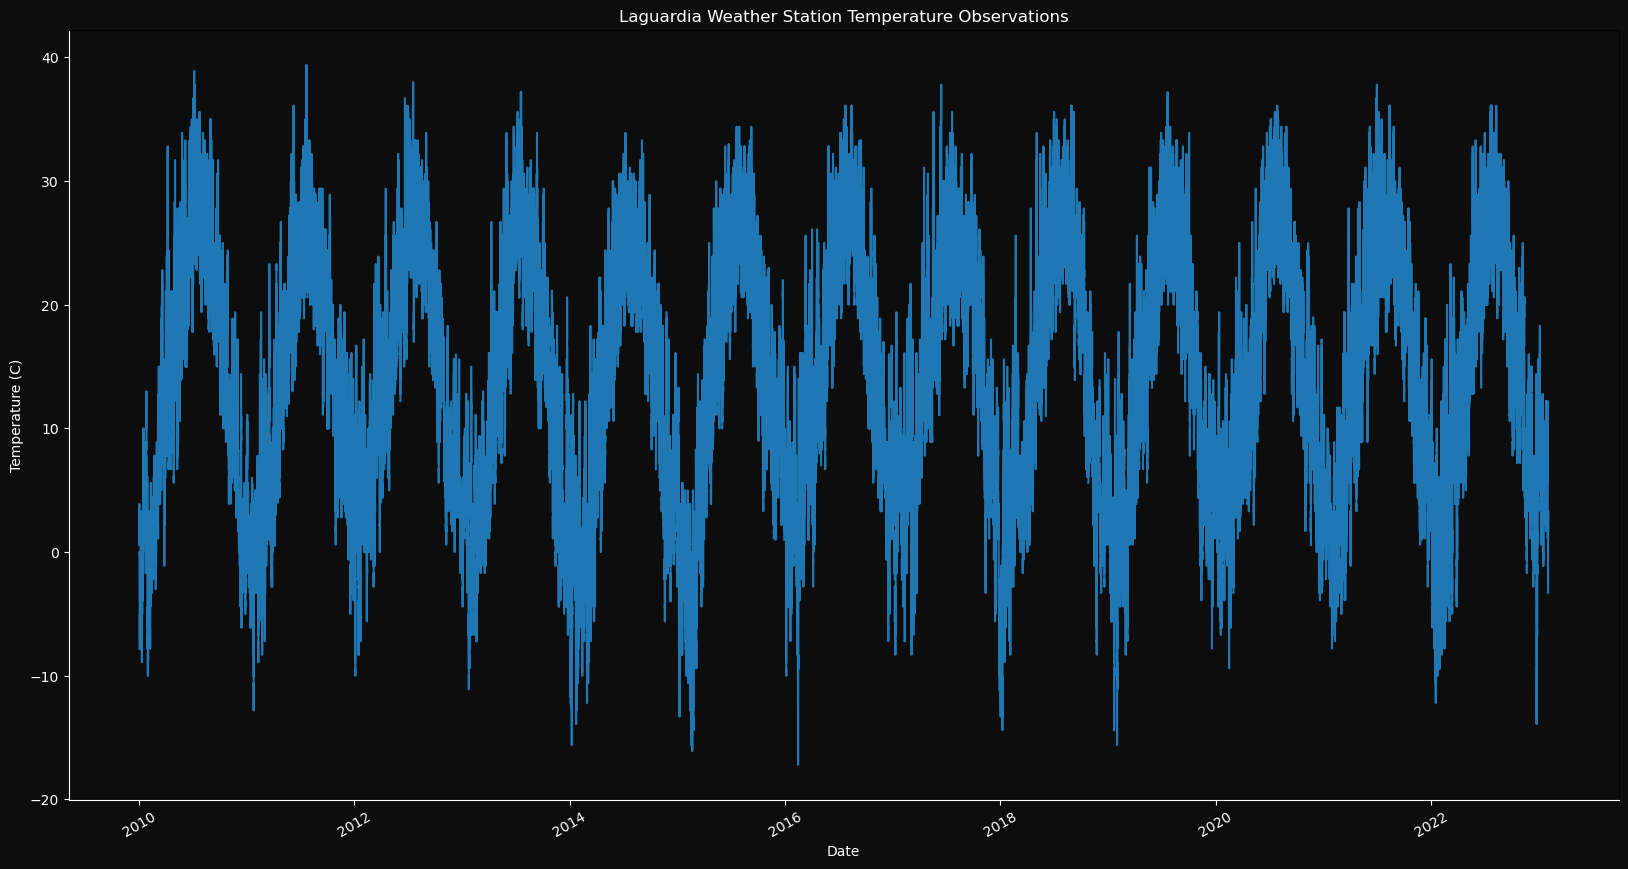

In [6]:
ax = weather_df[['DATE', 'temperature_c']].plot(
    x='DATE', y='temperature_c',
    xlabel='Date', ylabel="Temperature (C)",
    title="Laguardia Weather Station Temperature Observations",
    legend=False)

ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
fig.set_size_inches((20,10))
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')
fig.savefig("../plots/laguardia_temperature.svg")

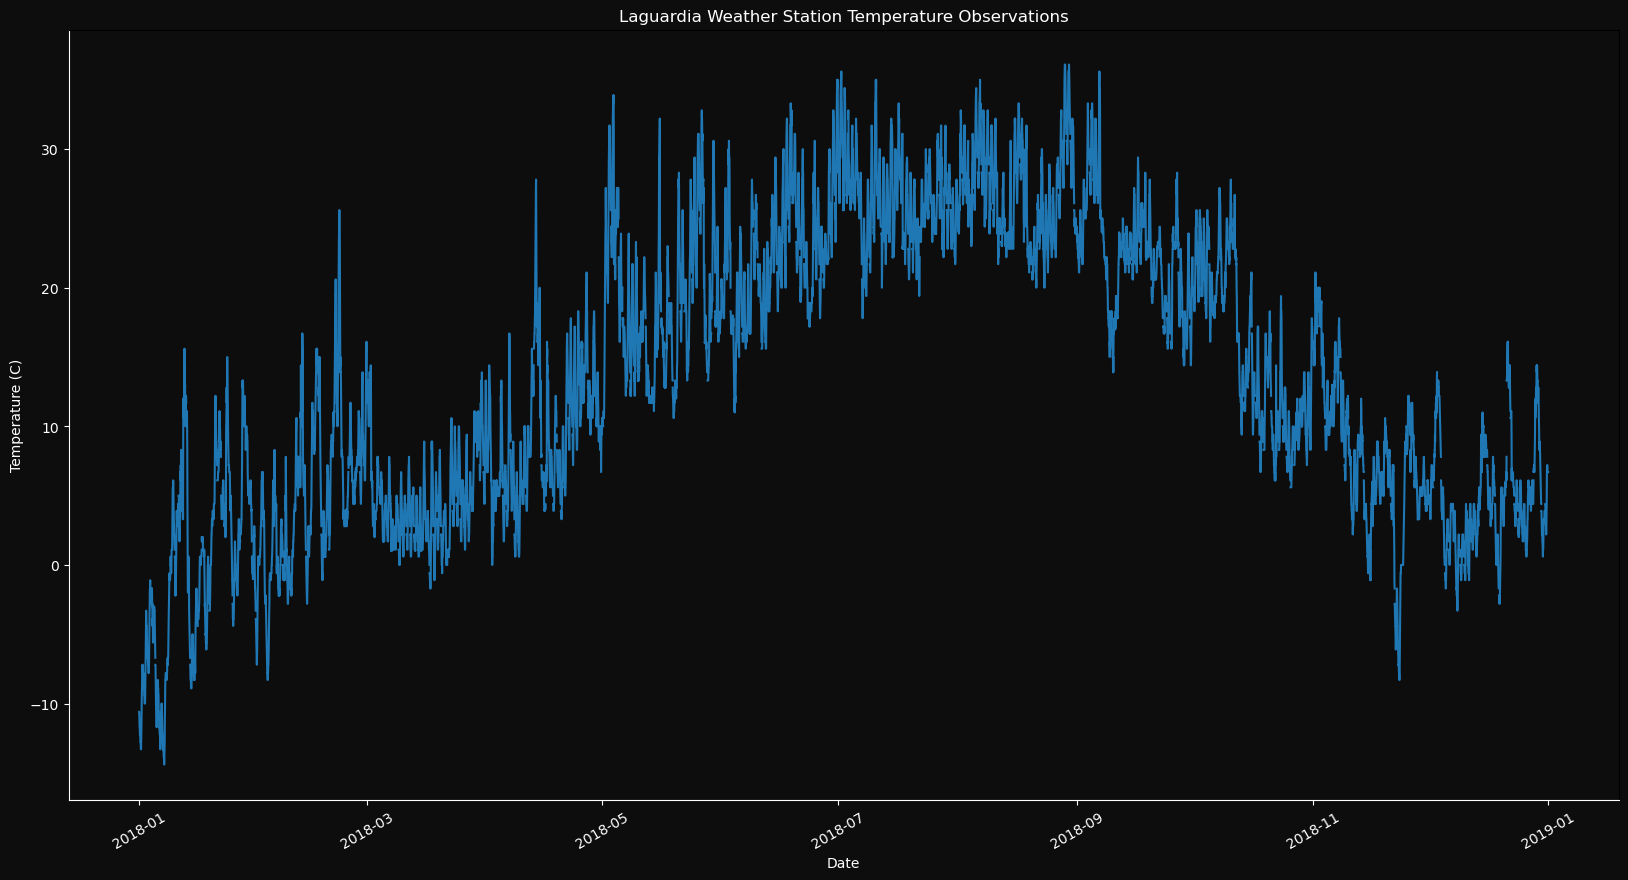

In [7]:


ax = weather_df[['DATE', 'temperature_c']]\
    [(weather_df['DATE']>=datetime.datetime(2018,1,1))
     &
     (weather_df['DATE']<datetime.datetime(2019,1,1))
     ].plot(
    x='DATE', y='temperature_c',
    xlabel='Date', ylabel="Temperature (C)",
    title="Laguardia Weather Station Temperature Observations",
    legend=False)

ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
fig.set_size_inches((20,10))
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')
fig.savefig("../plots/laguardia_temp_2018.svg")


In [63]:


df_2018 = weather_df[['DATE', 'temperature_c']]\
    [(weather_df['DATE']>=datetime.datetime(2018,1,1))
     &
     (weather_df['DATE']<datetime.datetime(2019,1,1))
     ].reset_index()
df_2018.rename({'DATE':'ds', 'temperature_c':'y', 'index':'unique_id'}, axis=1, inplace=True)

df_2018.dropna(subset=['y'], inplace=True)

df_2018['ds'] = df_2018['ds'].dt.round('5min').astype('datetime64[s]')

In [64]:
df_2018.drop_duplicates(subset=['ds'], inplace=True)
df_2018.set_index('unique_id', inplace=True)
df_2018.describe()

,ds,y
count,13482,13482.000000
mean,2018-07-02 06:18:44,13.690447
min,2018-01-01 00:00:00,-14.400000
25%,2018-03-31 17:52:30,5.000000
50%,2018-07-01 18:25:00,12.800000
75%,2018-10-01 12:37:30,22.800000
max,2018-12-31 23:50:00,36.100000
std,NaN,10.101014


In [65]:
# check_autocorr_ts(df_2018.set_index('ds'), lags=(12*24))

In [66]:
# df_2018 = df_2018.reset_index().set_index('ds').asfreq('5min').reset_index()

df_2018 = df_2018.reset_index()

In [67]:
df_2018 = df_2018.convert_dtypes(dtype_backend='numpy_nullable')

df_2018.drop('unique_id', inplace=True, axis=1)
df_2018.reset_index(inplace=True)
df_2018.rename({'DATE':'ds', 'temperature_c':'y', 'index':'unique_id'}, axis=1, inplace=True)

In [68]:
df_2018

,unique_id,ds,y
0,0,2018-01-01 00:00:00,-10.6
1,1,2018-01-01 00:50:00,-10.6
2,2,2018-01-01 01:50:00,-11.1
3,3,2018-01-01 02:50:00,-11.7
4,4,2018-01-01 03:00:00,-11.7
...,...,...,...
13477,13477,2018-12-31 21:50:00,6.7
13478,13478,2018-12-31 22:50:00,6.7
13479,13479,2018-12-31 23:25:00,6.7
13480,13480,2018-12-31 23:40:00,6.7


In [97]:

sf = StatsForecast(
    models = [AutoARIMA(season_length = 12*24)],
    freq = '5min',
    verbose=True
)
sf.fit(df_2018)
pred = sf.predict(h=12, level=[99])

c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [102]:
((pred['AutoARIMA-hi-99']-pred['AutoARIMA-lo-99'])**2).mean()


0.0

In [108]:
print(sf.models[0].D)

None


In [106]:
dir(sf)
dir(sf.models[0])

['D',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_conformal_intervals',
 '_add_predict_conformal_intervals',
 '_conformal_method',
 '_conformity_scores',
 '_store_cs',
 'alias',
 'allowdrift',
 'allowmean',
 'approximation',
 'biasadj',
 'blambda',
 'd',
 'fit',
 'forecast',
 'forward',
 'ic',
 'max_D',
 'max_P',
 'max_Q',
 'max_d',
 'max_order',
 'max_p',
 'max_q',
 'method',
 'new',
 'nmodels',
 'predict',
 'predict_in_sample',
 'prediction_intervals',
 'season_length',
 'seasonal',
 'seasonal_test',
 'seasonal_test_kwargs',
 'start_P',
 'start_Q',
 'start_p',
 'start_q',
 'stationary',
 'stepwise',
 'test',
 'test_kwargs',
 'trace',
 'truncate',
 'uses_exo

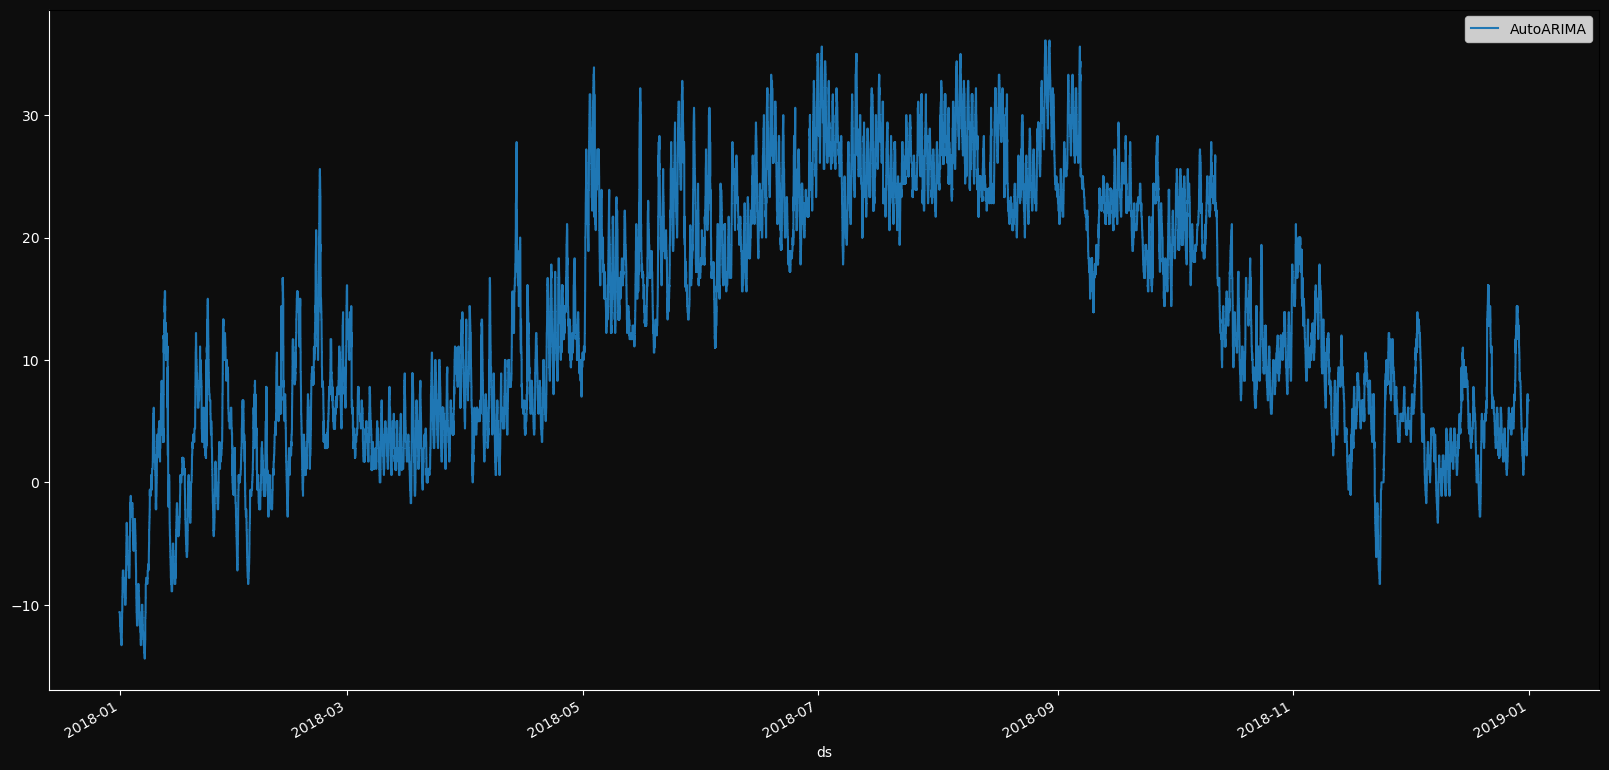

In [111]:

ax = pred.plot(x='ds', y='AutoARIMA')
ax.fill_between(pred['ds'], y2=pred['AutoARIMA-lo-99'],y1=pred['AutoARIMA-hi-99'])
fig =  ax.get_figure()
ax.set_facecolor("#0d0d0d")
fig = ax.get_figure()
fig.set_facecolor("#0d0d0d")
fig.set_size_inches((20,10))
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')
# fig.savefig("../plots/laguardia_temp_2018.svg")

c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:1316: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


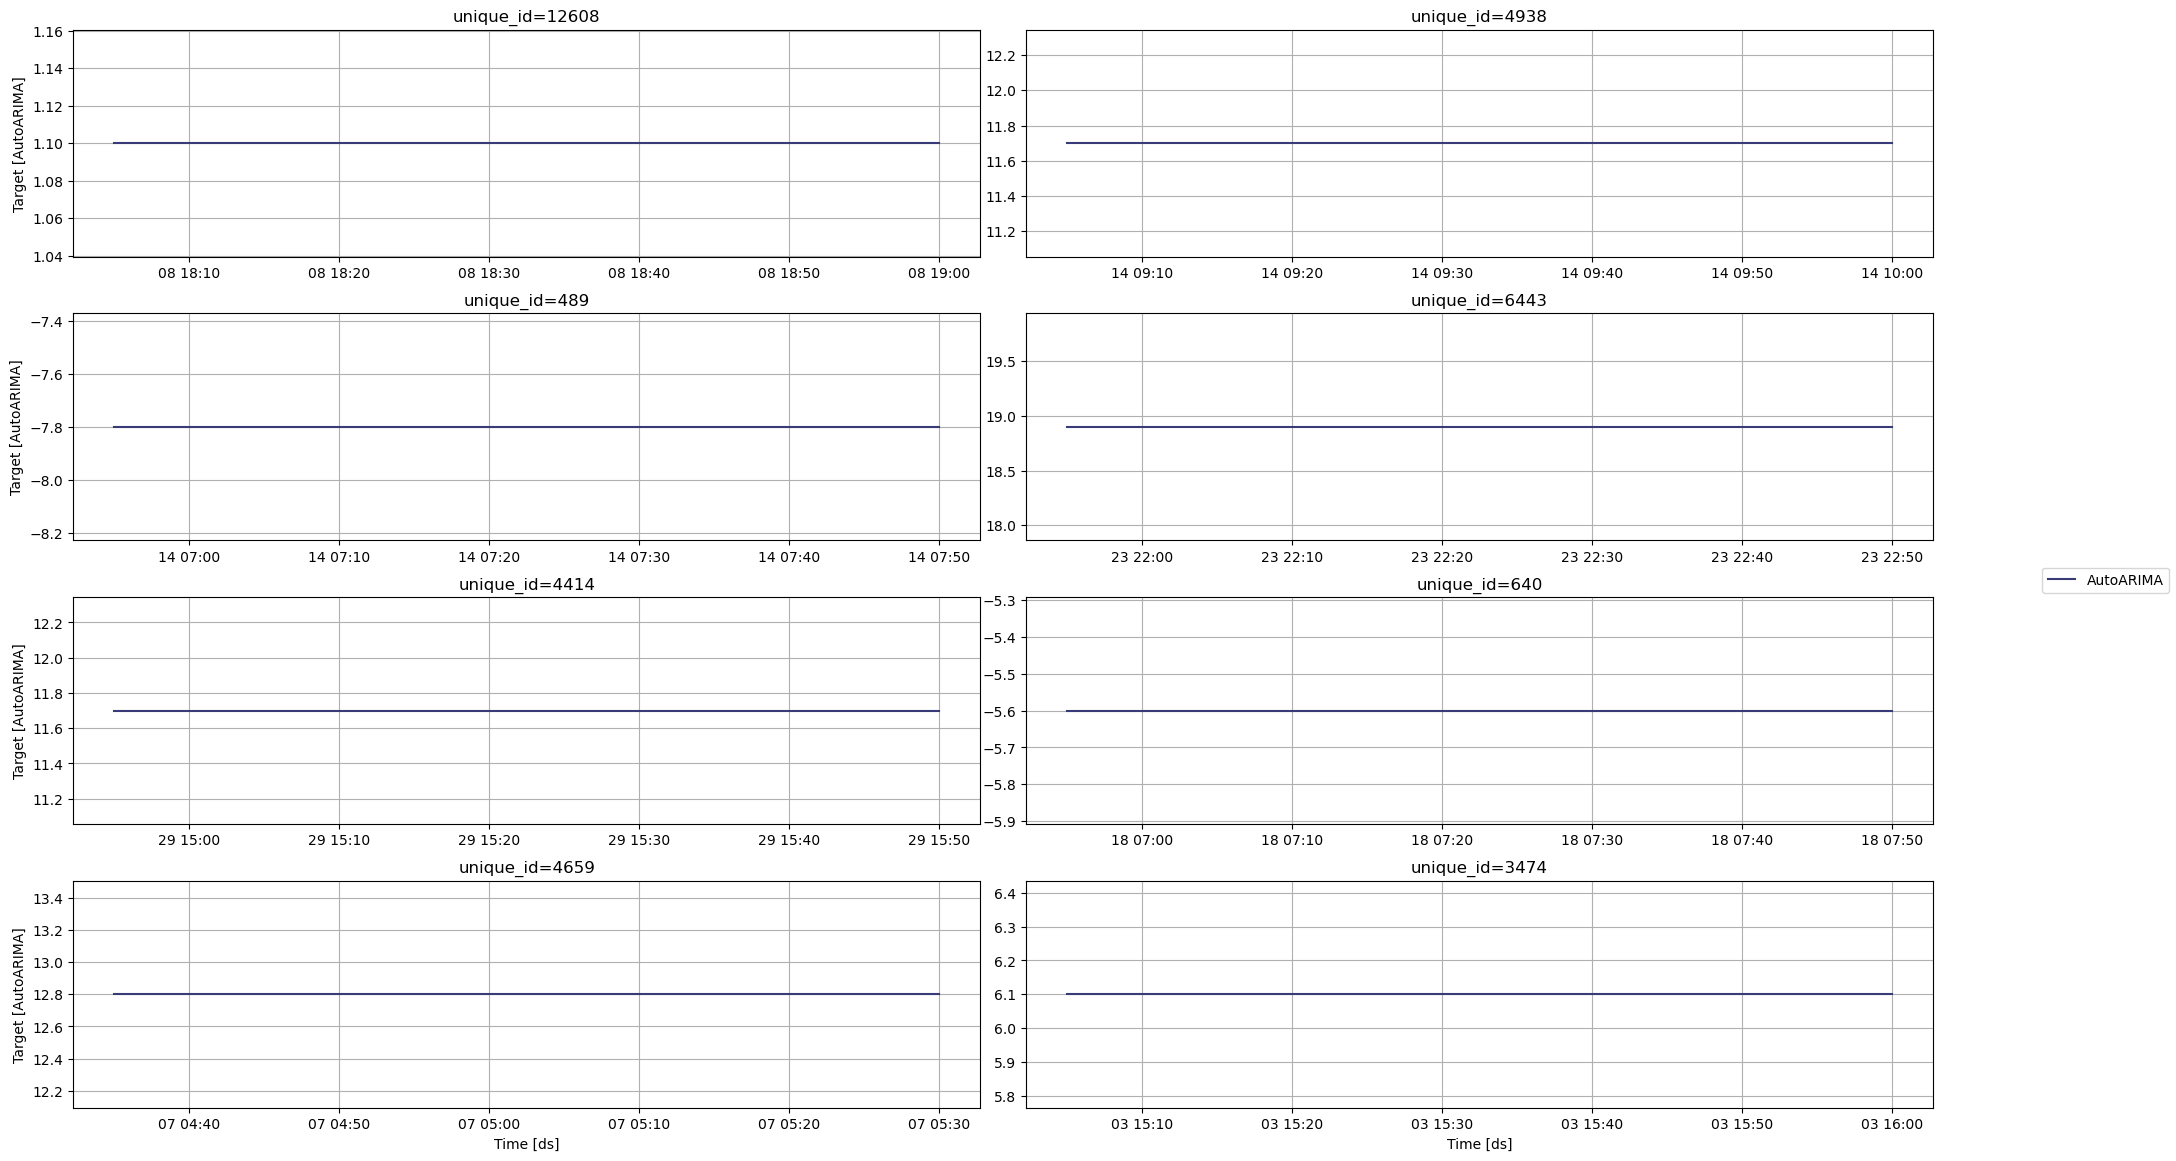

In [80]:
StatsForecast.plot(df=pred, target_col='AutoARIMA')
